In [1]:
import gym
import gym_example
from utils import *

# Training protagonist and adversary

To train adversarial v-3, which includes training of the protagonist to compute reward -later it will be regret, when we include both protagonist and antagonist-. For each environment generated by the adversary we can visualize how it looks, shortest path between agent and goal, and the cumulative reward achieved by the protagonist.

### Without running ray

Shortest path:  20


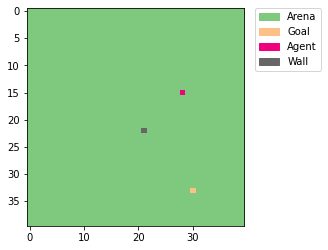

Converting ./models/protagonist/AnimalAI/frozen_graph_def.pb to ./models/protagonist/AnimalAI.nn
GLOBALS: 'is_continuous_control', 'version_number', 'memory_size', 'action_output_shape'
IN: 'visual_observation_0': [-1, 84, 84, 3] => 'policy/main_graph_0_encoder0/conv_1/BiasAdd'
IN: 'vector_observation': [-1, 1, 1, 3] => 'policy/main_graph_0/hidden_0/BiasAdd'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice_1'
OUT: 'policy/concat/concat', 'action'
DONE: wrote ./models/protagonist/AnimalAI.nn file.
PROTAGONIST: 
Steps:  30000  Cumulative reward:  -0.0685985733099205  Episode Length:  199.14285714285717
Steps:  30000  Cumulative reward:  -0.0685985733099205  Episode Length:  199.14285714285717
Steps:  30000  Cumulative reward:  -0.0685985733099205  Episode Length:  199.14285714285717


Process Process-2:
Traceback (most recent call last):
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/animalai_train/subprocess_env_manager_aai.py", line 43, in worker_aai
    worker_id, [shared_float_properties, engine_configuration_channel]
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/animalai_train/environment_factory_aai.py", line 56, in create_unity_environment
    side_channels=side_channels,
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/animalai/envs/environment.py", line 64, in __init__
    side_channels=self.side_channels,
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site

ANTAGONIST: 
Steps:  30000  Cumulative reward:  -0.0685985733099205  Episode Length:  199.14285714285717
Steps:  30000  Cumulative reward:  -0.0685985733099205  Episode Length:  199.14285714285717
Steps:  30000  Cumulative reward:  -0.0685985733099205  Episode Length:  199.14285714285717
Sum reward:  0.0


In [2]:
env = gym.make("adversarial-v4")
sum_reward = run_one_episode(env)
print('Sum reward: ', sum_reward)

In [ ]:
sum_reward = run_one_episode(env)
print('Sum reward: ', sum_reward)

## Running ray 

In [2]:
import os
import shutil

chkpt_root = "tmp/w_PAIRED_0"

shutil.rmtree(chkpt_root, ignore_errors=True, onerror=None)
ray_results = "{}/ray_results/".format(os.getenv("HOME"))
shutil.rmtree(ray_results, ignore_errors=True, onerror=None)

In [3]:
import ray

ray.init(ignore_reinit_error=True, local_mode=True)

2021-04-14 20:20:11,860	INFO services.py:1174 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '10.100.0.236',
 'raylet_ip_address': '10.100.0.236',
 'redis_address': '10.100.0.236:6379',
 'object_store_address': '/tmp/ray/session_2021-04-14_20-20-11_337319_7243/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-04-14_20-20-11_337319_7243/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-04-14_20-20-11_337319_7243',
 'metrics_export_port': 63123,
 'node_id': '449feac16ce4de1c826ad09ed1e9237ac5732e38f5a4ab8a4014b0fb'}

In [4]:
from ray.tune.registry import register_env
from gym_example.envs.adversarial_v4 import Adversarial_v4
import ray.rllib.agents.ppo as ppo

select_env = "adversarial-v4"
register_env(select_env, lambda config: Adversarial_v4())

config = ppo.DEFAULT_CONFIG.copy()

config["log_level"] = "WARN"
agent = ppo.PPOTrainer(config, env=select_env)

2021-04-14 20:20:18,657	INFO trainer.py:616 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-04-14 20:20:18,657	INFO trainer.py:643 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2021-04-14 20:20:18,733	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-04-14 20:20:19,773	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-04-14 20:20:20,728	WARNING deprecation.py:34 -- DeprecationWarning: `framestack` has been deprecated. Use `num_framestacks (int)` instead. This will raise an error in the future!
2021-04-14 20:20:23,334	WARNING util.py:47 -- Install gputil for GPU system monitoring.


Shortest path:  32


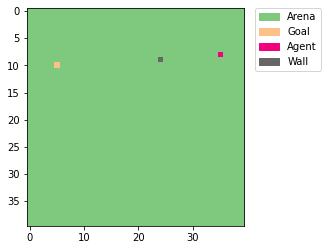

Converting ./models/protagonist/AnimalAI/frozen_graph_def.pb to ./models/protagonist/AnimalAI.nn
GLOBALS: 'is_continuous_control', 'version_number', 'memory_size', 'action_output_shape'
IN: 'visual_observation_0': [-1, 84, 84, 3] => 'policy/main_graph_0_encoder0/conv_1/BiasAdd'
IN: 'vector_observation': [-1, 1, 1, 3] => 'policy/main_graph_0/hidden_0/BiasAdd'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice_1'
OUT: 'policy/concat/concat', 'action'
DONE: wrote ./models/protagonist/AnimalAI.nn file.
PROTAGONIST: 
Steps:  10000  Cumulative reward:  -0.9999999310821296  Episode Length:  248.0
Steps:  10000  Cumulative reward:  -0.9999999310821296  Episode Length:  248.0
Steps:  10000  Cumulative reward:  -0.9999999310821296  Episode Length:  248.0
Converting ./models/antagonist/AnimalAI/frozen_graph_def.pb to ./models/antagonist/AnimalAI.nn
GLOBALS: 'is_continuous_control', 'version_number', 'memory_size', 'action_out

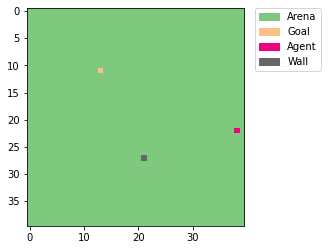

Converting ./models/protagonist/AnimalAI/frozen_graph_def.pb to ./models/protagonist/AnimalAI.nn
GLOBALS: 'is_continuous_control', 'version_number', 'memory_size', 'action_output_shape'
IN: 'visual_observation_0': [-1, 84, 84, 3] => 'policy/main_graph_0_encoder0/conv_1/BiasAdd'
IN: 'vector_observation': [-1, 1, 1, 3] => 'policy/main_graph_0/hidden_0/BiasAdd'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice_1'
OUT: 'policy/concat/concat', 'action'
DONE: wrote ./models/protagonist/AnimalAI.nn file.
PROTAGONIST: 
Steps:  20000  Cumulative reward:  -0.7778535881647612  Episode Length:  241.34146341463412
Steps:  20000  Cumulative reward:  -0.7778535881647612  Episode Length:  241.34146341463412
Steps:  20000  Cumulative reward:  -0.7778535881647612  Episode Length:  241.34146341463412
Converting ./models/antagonist/AnimalAI/frozen_graph_def.pb to ./models/antagonist/AnimalAI.nn
GLOBALS: 'is_continuous_control', 'vers

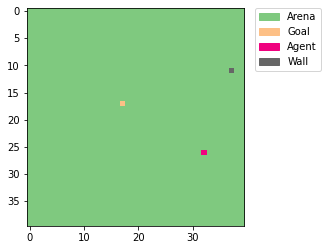

Converting ./models/protagonist/AnimalAI/frozen_graph_def.pb to ./models/protagonist/AnimalAI.nn
GLOBALS: 'is_continuous_control', 'version_number', 'memory_size', 'action_output_shape'
IN: 'visual_observation_0': [-1, 84, 84, 3] => 'policy/main_graph_0_encoder0/conv_1/BiasAdd'
IN: 'vector_observation': [-1, 1, 1, 3] => 'policy/main_graph_0/hidden_0/BiasAdd'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice_1'
OUT: 'policy/concat/concat', 'action'
DONE: wrote ./models/protagonist/AnimalAI.nn file.
PROTAGONIST: 
Steps:  30000  Cumulative reward:  -0.0685985733099205  Episode Length:  199.14285714285717
Steps:  30000  Cumulative reward:  -0.0685985733099205  Episode Length:  199.14285714285717
Steps:  30000  Cumulative reward:  -0.0685985733099205  Episode Length:  199.14285714285717
Converting ./models/antagonist/AnimalAI/frozen_graph_def.pb to ./models/antagonist/AnimalAI.nn
GLOBALS: 'is_continuous_control', 'vers

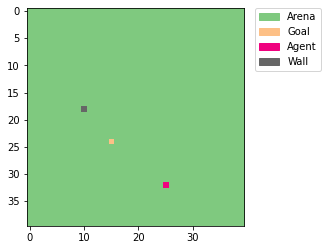

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f8edec3a950>
Traceback (most recent call last):
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/weakref.py", line 358, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 


Converting ./models/protagonist/AnimalAI/frozen_graph_def.pb to ./models/protagonist/AnimalAI.nn
GLOBALS: 'is_continuous_control', 'version_number', 'memory_size', 'action_output_shape'
IN: 'visual_observation_0': [-1, 84, 84, 3] => 'policy/main_graph_0_encoder0/conv_1/BiasAdd'
IN: 'vector_observation': [-1, 1, 1, 3] => 'policy/main_graph_0/hidden_0/BiasAdd'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice_1'
OUT: 'policy/concat/concat', 'action'
DONE: wrote ./models/protagonist/AnimalAI.nn file.
PROTAGONIST: 
Steps:  30000  Cumulative reward:  -0.0685985733099205  Episode Length:  199.14285714285717
Steps:  30000  Cumulative reward:  -0.0685985733099205  Episode Length:  199.14285714285717
Steps:  30000  Cumulative reward:  -0.0685985733099205  Episode Length:  199.14285714285717


Process Process-8:
Traceback (most recent call last):
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/mlagents_envs/rpc_communicator.py", line 77, in check_port
    s.bind(("localhost", port))
OSError: [Errno 98] Address already in use

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/animalai_train/subprocess_env_manager_aai.py", line 43, in worker_aai
    worker_id, [shared_float_properties, engine_configuration_channel]
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/animalai_train/environment_factory_

Shortest path:  24


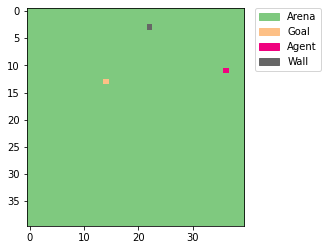

Traceback (most recent call last):
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


PROTAGONIST: 
Steps:  30000  Cumulative reward:  -0.0685985733099205  Episode Length:  199.14285714285717
Steps:  30000  Cumulative reward:  -0.0685985733099205  Episode Length:  199.14285714285717
Steps:  30000  Cumulative reward:  -0.0685985733099205  Episode Length:  199.14285714285717


Process Process-10:
Traceback (most recent call last):
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/mlagents_envs/rpc_communicator.py", line 77, in check_port
    s.bind(("localhost", port))
OSError: [Errno 98] Address already in use

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/animalai_train/subprocess_env_manager_aai.py", line 43, in worker_aai
    worker_id, [shared_float_properties, engine_configuration_channel]
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/animalai_train/environment_factory

RayTaskError(ConnectionResetError): [36mray::RolloutWorker.par_iter_next()[39m (pid=7243, ip=10.100.0.236)
  File "python/ray/_raylet.pyx", line 480, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 432, in ray._raylet.execute_task.function_executor
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/util/iter.py", line 1152, in par_iter_next
    return next(self.local_it)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/evaluation/rollout_worker.py", line 327, in gen_rollouts
    yield self.sample()
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/evaluation/rollout_worker.py", line 662, in sample
    batches = [self.input_reader.next()]
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/evaluation/sampler.py", line 95, in next
    batches = [self.get_data()]
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/evaluation/sampler.py", line 224, in get_data
    item = next(self.rollout_provider)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/evaluation/sampler.py", line 686, in _env_runner
    base_env.send_actions(actions_to_send)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/env/base_env.py", line 346, in send_actions
    self.vector_env.vector_step(action_vector)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/ray/rllib/env/vector_env.py", line 143, in vector_step
    obs, r, done, info = self.envs[i].step(actions[i])
  File "/home/psanchezlopez/Documents/AnimalAI-Olympics/examples/adversary_design/gym_example/envs/adversarial_v4.py", line 124, in step
    load_model=self.load_model)
  File "/home/psanchezlopez/Documents/AnimalAI-Olympics/examples/adversary_design/utils.py", line 247, in train_antagonist
    run_training_aai(0, args)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/animalai_train/run_training_aai.py", line 113, in run_training_aai
    tc.start_learning(env_manager)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/mlagents_envs/timers.py", line 258, in wrapped
    return func(*args, **kwargs)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/mlagents/trainers/trainer_controller.py", line 201, in start_learning
    self._reset_env(env_manager)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/mlagents_envs/timers.py", line 258, in wrapped
    return func(*args, **kwargs)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/animalai_train/trainer_controller_aai.py", line 48, in _reset_env
    env.reset(config=new_meta_curriculum_config)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/mlagents/trainers/env_manager.py", line 57, in reset
    self.first_step_infos = self._reset_env(config)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/animalai_train/subprocess_env_manager_aai.py", line 143, in _reset_env
    ew.previous_step = EnvironmentStep(ew.recv().payload, ew.worker_id, {})
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/site-packages/mlagents/trainers/subprocess_env_manager.py", line 66, in recv
    response: EnvironmentResponse = self.conn.recv()
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/psanchezlopez/anaconda3/envs/animalai/lib/python3.7/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
ConnectionResetError: [Errno 104] Connection reset by peer

In [5]:
status = "{:2d} reward {:6.2f}/{:6.2f}/{:6.2f} len {:4.2f} saved {}"
n_iter = 1
for n in range(n_iter):
    result = agent.train()
    chkpt_file = agent.save(chkpt_root)
    print(status.format(
            n + 1,
            result["episode_reward_min"],
            result["episode_reward_mean"],
            result["episode_reward_max"],
            result["episode_len_mean"],
            chkpt_file
            ))